In [73]:
import pandas as pd
df = pd.read_csv('/Users/jono/Downloads/reactivation.csv')
df2 = pd.read_csv('/Users/jono/Downloads/DAILY_ANALYSIS.csv')

In [57]:
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16193 entries, 0 to 16192
Columns: 136 entries, SOURCE to POST_D49
dtypes: int64(126), object(10)
memory usage: 16.8+ MB


Converting START_DATE to datetime...
Melting based on 120 available day columns...
Value counts for Group column:
Group
Reactivation B    720360
Reactivation A    631320
Onboarding        591480
Name: count, dtype: int64
df_analysis DataFrame created successfully.
Calculating initial daily aggregates...
Initial daily aggregates calculated.
Generating initial plots...


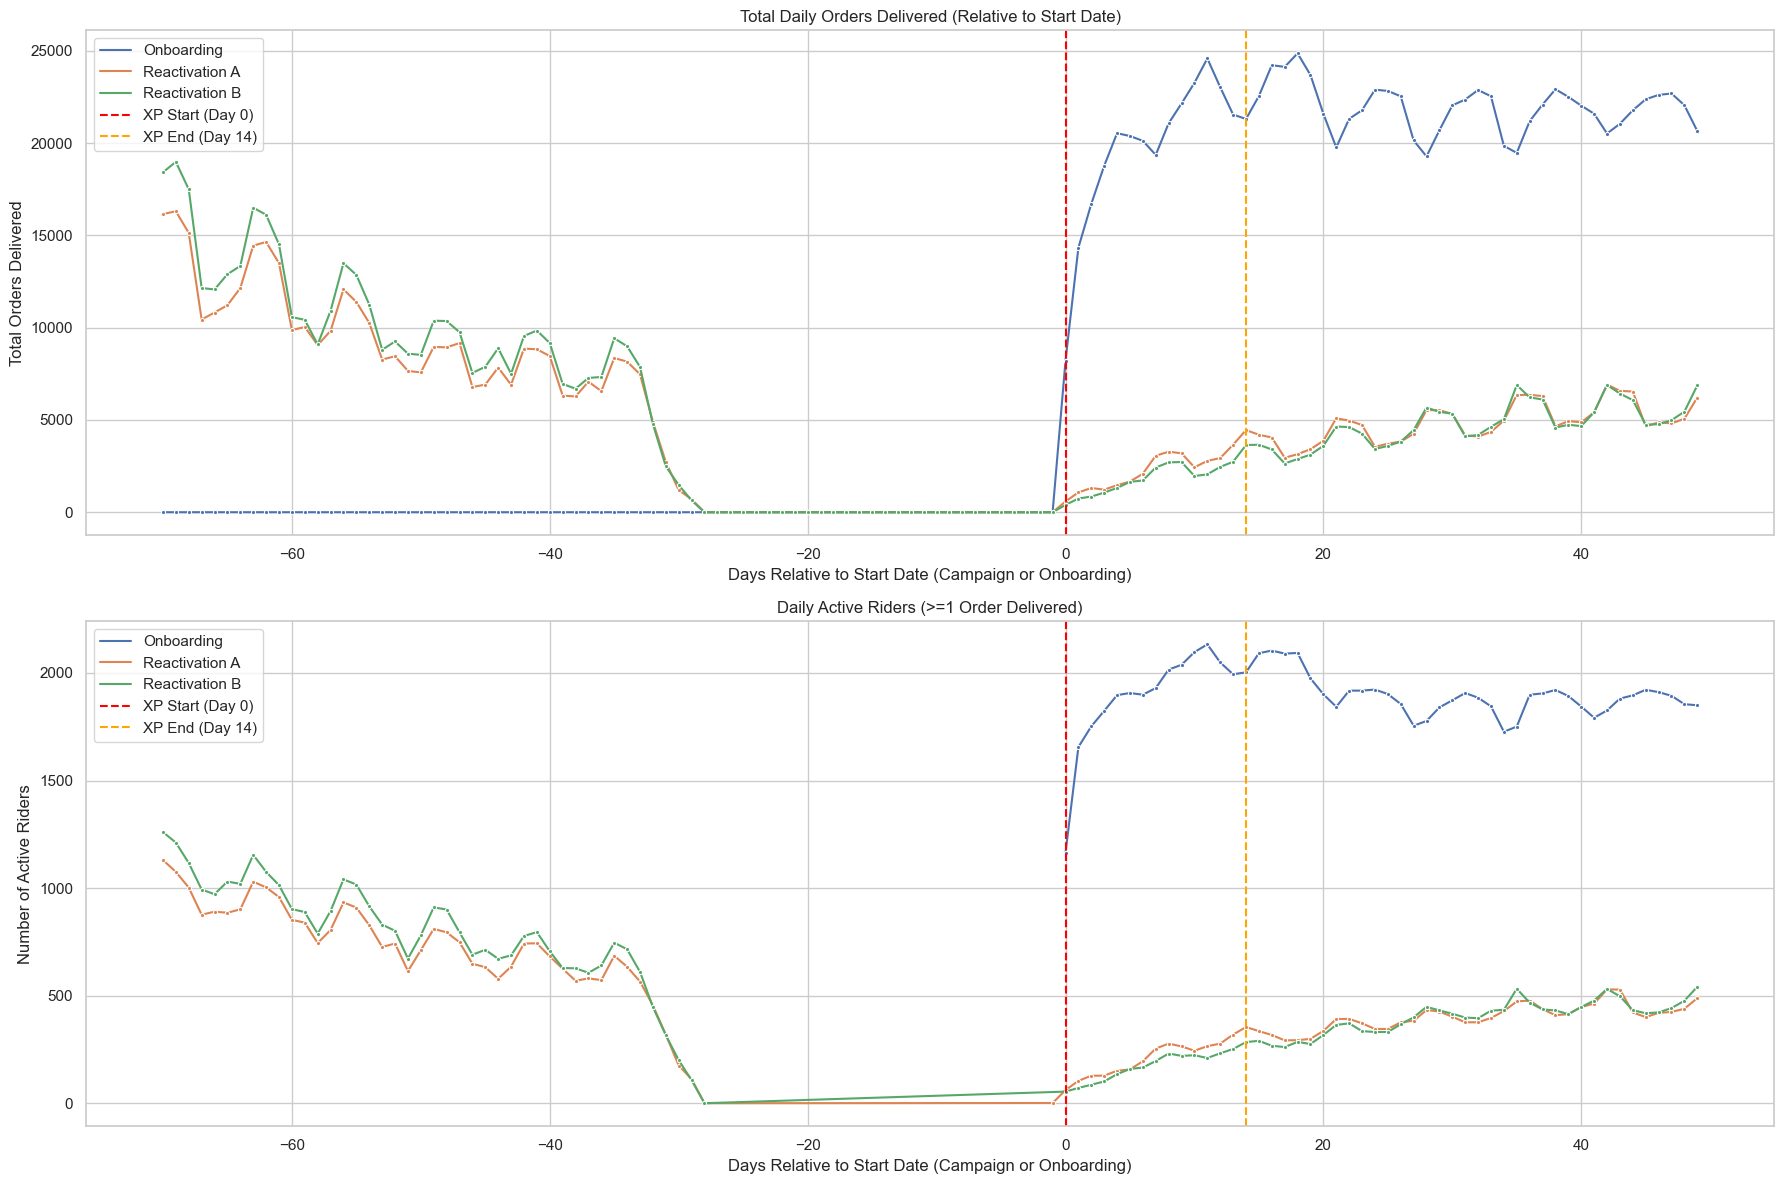

In [75]:
# --- Step 2 (Re-run): Reshape Data and Initial Plotting --- 

import matplotlib.pyplot as plt
import seaborn as sns
import re # For parsing day numbers
import pandas as pd # Ensure pandas is imported

# Ensure df2 is loaded and START_DATE is datetime 
# (Assuming df2 is loaded correctly from Step 1)
if 'df2' not in locals():
    print("Error: df2 not found. Please run the first cell loading data.")
else:
    if 'START_DATE' in df2.columns and not pd.api.types.is_datetime64_any_dtype(df2['START_DATE']):
         print("Converting START_DATE to datetime...")
         df2['START_DATE'] = pd.to_datetime(df2['START_DATE'], errors='coerce')
         df2.dropna(subset=['START_DATE'], inplace=True) # Drop if conversion failed


    # --- Data Preparation: Reshape to Long Format ---

    # Define all relevant day columns
    pre_cols = [f'PRE_D{i}' for i in range(70, 0, -1)] # D70 to D1
    xp_cols = [f'XP_D{i}' for i in range(15)]        # D0 to D14
    post_cols = [f'POST_D{i}' for i in range(15, 72)] # D15 to D71 (Adjust max if needed)
    all_day_cols = pre_cols + xp_cols + post_cols

    # Check which day columns actually exist in df2
    available_day_cols = [col for col in all_day_cols if col in df2.columns]
    missing_day_cols = [col for col in all_day_cols if col not in available_day_cols]
    if missing_day_cols:
        print(f"Warning: Missing day columns, they will be skipped: {missing_day_cols}")
    if not available_day_cols:
         print("Error: No day columns (PRE_D*, XP_D*, POST_D*) found in df2. Cannot proceed.")
    else:
        # Columns to keep when melting (ensure they exist)
        # Include VEHICLE_TYPE if it exists, crucial for later steps
        base_id_vars = ['SOURCE', 'DRIVER_ID', 'START_DATE', 'GROUP_FIXED', 'CITY', 'VEHICLE_TYPE'] 
        id_vars = [col for col in base_id_vars if col in df2.columns]
        missing_id_vars = [col for col in base_id_vars if col not in id_vars]
        if missing_id_vars:
            print(f"Warning: Missing ID columns for melting: {missing_id_vars}")
        # Check essential columns needed for core analysis
        if not all(col in id_vars for col in ['SOURCE', 'DRIVER_ID', 'START_DATE', 'GROUP_FIXED']):
            print("Error: Essential columns (SOURCE, DRIVER_ID, START_DATE, GROUP_FIXED) missing. Cannot proceed.")
        else:
            # Melt the DataFrame
            print(f"Melting based on {len(available_day_cols)} available day columns...")
            df_long = pd.melt(df2, 
                              id_vars=id_vars, 
                              value_vars=available_day_cols, 
                              var_name='Day_Str', 
                              value_name='Orders')

            # Convert Orders to numeric, coercing errors
            df_long['Orders'] = pd.to_numeric(df_long['Orders'], errors='coerce').fillna(0).astype(int)

            # --- Calculate Relative Day --- 
            def get_relative_day(day_str):
                match = re.match(r"(PRE|XP|POST)_D(\d+)", day_str)
                if match:
                    prefix, number = match.groups()
                    number = int(number)
                    if prefix == 'PRE':
                        return -number 
                    else: # XP or POST
                        return number
                return None 

            df_long['Relative_Day'] = df_long['Day_Str'].apply(get_relative_day)
            df_long.dropna(subset=['Relative_Day'], inplace=True)
            df_long['Relative_Day'] = df_long['Relative_Day'].astype(int)

            # --- Define Analysis Group --- 
            def assign_group(row):
                source = row.get('SOURCE', None)
                group_fixed = row.get('GROUP_FIXED', None) 
                if source == 'Onboarding':
                    return 'Onboarding'
                elif source == 'Reactivation':
                    if group_fixed == 'A':
                        return 'Reactivation A'
                    elif group_fixed == 'B':
                        return 'Reactivation B'
                return 'Other' 

            df_long['Group'] = df_long.apply(assign_group, axis=1)
            
            # CREATE df_analysis HERE
            print(f"Value counts for Group column:\n{df_long['Group'].value_counts()}")
            df_analysis = df_long[df_long['Group'] != 'Other'].copy()
            
            if df_analysis.empty:
                 print("Error: df_analysis is empty after filtering groups.")
            else:
                print("df_analysis DataFrame created successfully.")
                
                # --- Calculate Daily Aggregates (needed for subsequent steps) --- 
                print("Calculating initial daily aggregates...")
                daily_orders = df_analysis.groupby(['Group', 'Relative_Day'])['Orders'].sum().reset_index()
                daily_active_riders = df_analysis[df_analysis['Orders'] > 0].groupby(['Group', 'Relative_Day'])['DRIVER_ID'].nunique().reset_index()
                daily_active_riders.rename(columns={'DRIVER_ID': 'Active_Riders'}, inplace=True)
                print("Initial daily aggregates calculated.")

                # --- Plotting (Optional - you can comment this out if you don't need the first plots again) --- 
                print("Generating initial plots...")
                sns.set(style="whitegrid")
                plt.figure(figsize=(18, 12))

                # Plot 1: Daily Order Volume
                plt.subplot(2, 1, 1) 
                sns.lineplot(data=daily_orders, x='Relative_Day', y='Orders', hue='Group', marker='.')
                plt.title('Total Daily Orders Delivered (Relative to Start Date)')
                plt.xlabel('Days Relative to Start Date (Campaign or Onboarding)')
                plt.ylabel('Total Orders Delivered')
                min_day, max_day = daily_orders['Relative_Day'].min(), daily_orders['Relative_Day'].max()
                if min_day <= 0 <= max_day: plt.axvline(x=0, color='red', linestyle='--', label='XP Start (Day 0)')
                if min_day <= 14 <= max_day: plt.axvline(x=14, color='orange', linestyle='--', label='XP End (Day 14)')
                plt.legend()
                plt.grid(True)

                # Plot 2: Daily Active Riders
                plt.subplot(2, 1, 2) 
                sns.lineplot(data=daily_active_riders, x='Relative_Day', y='Active_Riders', hue='Group', marker='.')
                plt.title('Daily Active Riders (>=1 Order Delivered)')
                plt.xlabel('Days Relative to Start Date (Campaign or Onboarding)')
                plt.ylabel('Number of Active Riders')
                min_day_act, max_day_act = daily_active_riders['Relative_Day'].min(), daily_active_riders['Relative_Day'].max()
                if min_day_act <= 0 <= max_day_act: plt.axvline(x=0, color='red', linestyle='--', label='XP Start (Day 0)')
                if min_day_act <= 14 <= max_day_act: plt.axvline(x=14, color='orange', linestyle='--', label='XP End (Day 14)')
                plt.legend()
                plt.grid(True)

                plt.tight_layout() 
                plt.show()


In [59]:
import pandas as pd

# Read the CSV, explicitly stating there's no index column in the file itself
# This ensures the first column ('SOURCE') is treated as data
df2 = pd.read_csv('/Users/jono/Downloads/DAILY_ANALYSIS.csv', index_col=None)

# Print the first 5 rows to see the structure and headers
print("--- df2 head ---")
print(df2.head())
print("\\n--- df2 columns ---")
# Print the list of column names pandas recognized
print(df2.columns)

# Keep the old df load if needed, or remove it
# df = pd.read_csv('/Users/jono/Downloads/reactivation.csv')

--- df2 head ---
       SOURCE COUNTRY_NAME  DRIVER_ID  START_DATE GROUP_FIXED       CITY  \
0  Onboarding      Ireland     984926  2025-03-10          \N     Dublin   
1  Onboarding           UK     974205  2025-02-12          \N     Exeter   
2  Onboarding           UK     984330  2025-03-07          \N     London   
3  Onboarding           UK     976315  2025-02-17          \N     London   
4  Onboarding           UK     973350  2025-02-10          \N  Sheffield   

  LAST_4W DAYS_SINCE_LAST_WORK X_VALUE Y_VALUE  ... POST_D40  POST_D41  \
0     \\N                  \\N     \\N     \\N  ...       10         5   
1     \\N                  \\N     \\N     \\N  ...        6        15   
2     \\N                  \\N     \\N     \\N  ...        0         0   
3     \\N                  \\N     \\N     \\N  ...        0         0   
4     \\N                  \\N     \\N     \\N  ...        9        16   

   POST_D42  POST_D43  POST_D44  POST_D45  POST_D46  POST_D47  POST_D48  \
0     

In [74]:
# Calculate Total Cost for Group A
import numpy as np # Import numpy for isnan check

# Identify XP columns (D0 to D14)
xp_cols = [f'XP_D{i}' for i in range(15)]

# Ensure df2 is loaded and contains necessary columns like 'SOURCE', 'GROUP_FIXED', 'X_VALUE', 'Y_VALUE', and xp_cols
# (Assuming df2 was loaded correctly in the first cell)

# Check if required columns exist
required_cols = ['SOURCE', 'GROUP_FIXED', 'X_VALUE', 'Y_VALUE'] + xp_cols
missing_req_cols = [col for col in required_cols if col not in df2.columns]

if missing_req_cols:
    print(f"Error: Missing required columns in df2: {missing_req_cols}")
    total_cost_a = 'Error'
else:
    # Filter for Group A ('Reactivation' Source and 'A' Group_Fixed)
    # Handle potential NaN values in GROUP_FIXED
    df_group_a = df2[(df2['SOURCE'] == 'Reactivation') & (df2['GROUP_FIXED'] == 'A')].copy()

    # Check if df_group_a is empty
    if df_group_a.empty:
        print("No data found for Reactivation Group A.")
        total_cost_a = 0
        eligible_riders_a = pd.DataFrame() # Define empty df for later print statement
    else:
        # Calculate total orders during XP for each rider in Group A
        # Ensure XP columns are numeric, coercing errors to NaN
        for col in xp_cols:
             df_group_a[col] = pd.to_numeric(df_group_a[col], errors='coerce')
        df_group_a['total_xp_orders'] = df_group_a[xp_cols].sum(axis=1, skipna=False) # Don't skip NaN sums initially

        # Ensure X_VALUE and Y_VALUE are numeric
        df_group_a['X_VALUE'] = pd.to_numeric(df_group_a['X_VALUE'], errors='coerce')
        df_group_a['Y_VALUE'] = pd.to_numeric(df_group_a['Y_VALUE'], errors='coerce')

        # Filter riders who met their XP order target
        # Requires total_xp_orders and X_VALUE to be non-NaN
        eligible_condition = (df_group_a['total_xp_orders'] >= df_group_a['X_VALUE']) & \
                             (~df_group_a['total_xp_orders'].isna()) & \
                             (~df_group_a['X_VALUE'].isna())
        eligible_riders_a = df_group_a[eligible_condition]

        # Calculate the total cost (sum of Y_VALUE for eligible riders)
        # Requires Y_VALUE to be non-NaN
        total_cost_a = eligible_riders_a['Y_VALUE'].sum(skipna=True)


    print(f"Total Incentive Cost for Group A: £{total_cost_a}")
    # Print some info about Group A for verification
    print(f"Number of riders in Group A: {len(df_group_a)}")
    if not df_group_a.empty and 'total_xp_orders' in df_group_a.columns:
        print(f"Number of Group A riders meeting target: {len(eligible_riders_a)}")
        print(f"Number of Group A riders with NaN Y_VALUE meeting target: {eligible_riders_a['Y_VALUE'].isna().sum()}")


Total Incentive Cost for Group A: £51280
Number of riders in Group A: 5261
Number of Group A riders meeting target: 388
Number of Group A riders with NaN Y_VALUE meeting target: 0


Pre-XP Avg Orders A: 5436.77, B: 6013.36, Norm Factor: 1.11
Pre-XP Avg Active A: 699.95, B: 783.60, Norm Factor: 1.12


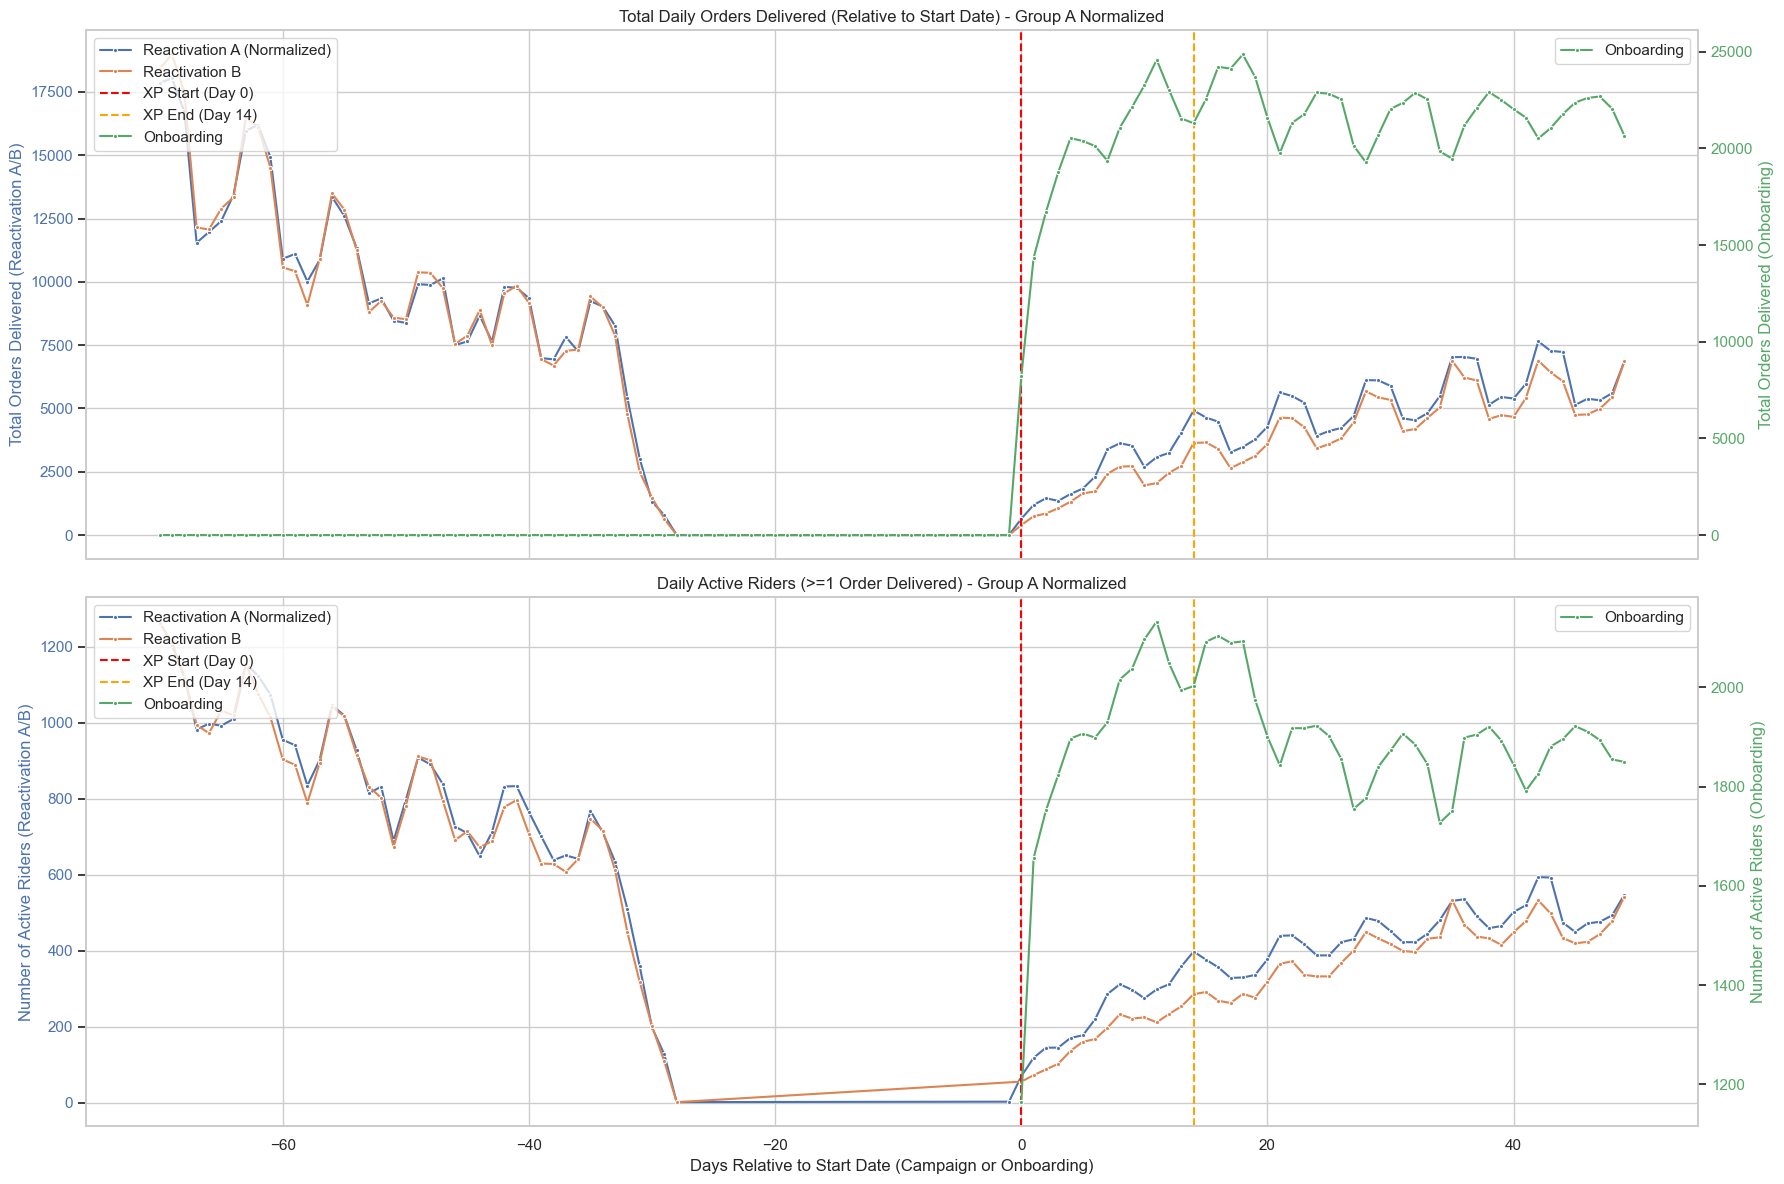

--- Daily Orders Head (Normalized A) ---
              Group  Relative_Day  Orders  Orders_Normalized
120  Reactivation A           -70   16150       17862.755338
121  Reactivation A           -69   16303       18031.981441
122  Reactivation A           -68   15127       16731.263158
123  Reactivation A           -67   10438       11544.980818
124  Reactivation A           -66   10818       11965.280944

--- Daily Active Riders Head (Normalized A) ---
             Group  Relative_Day  Active_Riders  Active_Riders_Normalized
50  Reactivation A           -70           1131               1266.163448
51  Reactivation A           -69           1076               1204.590513
52  Reactivation A           -68           1003               1122.866435
53  Reactivation A           -67            877                981.808438
54  Reactivation A           -66            891                997.481549


In [76]:
# --- Step 3: Normalize Group A and Plot with Dual Y-Axes --- 

import matplotlib.pyplot as plt
import seaborn as sns
import re # For parsing day numbers
import pandas as pd # Ensure pandas is imported
import numpy as np # Needed for nan checks if averages are zero


# --- Calculate Normalization Factors (Based on Pre-XP Averages) --- 
# Check if dataframes exist before proceeding
if 'daily_orders' not in locals() or 'daily_active_riders' not in locals():
    print("Error: 'daily_orders' or 'daily_active_riders' DataFrame not found.")
    print("Please ensure the previous cell (Step 2) has been run successfully.")
else:
    pre_xp_period_orders = daily_orders['Relative_Day'] < 0
    pre_xp_period_active = daily_active_riders['Relative_Day'] < 0

    # Calculate average pre-XP orders
    orders_a_pre = daily_orders[(daily_orders['Group'] == 'Reactivation A') & pre_xp_period_orders]
    orders_b_pre = daily_orders[(daily_orders['Group'] == 'Reactivation B') & pre_xp_period_orders]
    avg_pre_orders_a = orders_a_pre['Orders'].mean() if not orders_a_pre.empty else 0
    avg_pre_orders_b = orders_b_pre['Orders'].mean() if not orders_b_pre.empty else 0


    # Calculate average pre-XP active riders
    active_a_pre = daily_active_riders[(daily_active_riders['Group'] == 'Reactivation A') & pre_xp_period_active]
    active_b_pre = daily_active_riders[(daily_active_riders['Group'] == 'Reactivation B') & pre_xp_period_active]
    avg_pre_active_a = active_a_pre['Active_Riders'].mean() if not active_a_pre.empty else 0
    avg_pre_active_b = active_b_pre['Active_Riders'].mean() if not active_b_pre.empty else 0


    # Determine normalization factors (handle potential division by zero or NaN)
    order_norm_factor = 1.0 # Default to 1 if calculation fails
    if avg_pre_orders_a is not None and not np.isnan(avg_pre_orders_a) and avg_pre_orders_a != 0 and \
       avg_pre_orders_b is not None and not np.isnan(avg_pre_orders_b):
        order_norm_factor = avg_pre_orders_b / avg_pre_orders_a

    active_norm_factor = 1.0 # Default to 1
    if avg_pre_active_a is not None and not np.isnan(avg_pre_active_a) and avg_pre_active_a != 0 and \
       avg_pre_active_b is not None and not np.isnan(avg_pre_active_b):
        active_norm_factor = avg_pre_active_b / avg_pre_active_a


    print(f"Pre-XP Avg Orders A: {avg_pre_orders_a:.2f}, B: {avg_pre_orders_b:.2f}, Norm Factor: {order_norm_factor:.2f}")
    print(f"Pre-XP Avg Active A: {avg_pre_active_a:.2f}, B: {avg_pre_active_b:.2f}, Norm Factor: {active_norm_factor:.2f}")

    # --- Apply Normalization --- 

    # Create copies to avoid modifying the original aggregated dataframes directly
    daily_orders_norm = daily_orders.copy()
    daily_active_riders_norm = daily_active_riders.copy()

    daily_orders_norm['Orders_Normalized'] = daily_orders_norm['Orders']
    daily_active_riders_norm['Active_Riders_Normalized'] = daily_active_riders_norm['Active_Riders']

    # Apply normalization factor only to Group A
    daily_orders_norm.loc[daily_orders_norm['Group'] == 'Reactivation A', 'Orders_Normalized'] = daily_orders_norm.loc[daily_orders_norm['Group'] == 'Reactivation A', 'Orders'] * order_norm_factor
    daily_active_riders_norm.loc[daily_active_riders_norm['Group'] == 'Reactivation A', 'Active_Riders_Normalized'] = daily_active_riders_norm.loc[daily_active_riders_norm['Group'] == 'Reactivation A', 'Active_Riders'] * active_norm_factor

    # --- Plotting with Dual Y-Axes --- 

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True) # Share x-axis

    # -- Plot 1: Daily Order Volume -- 
    ax1_orders = axes[0]
    ax2_orders = ax1_orders.twinx() # instantiate a second axes that shares the same x-axis

    # Get color palette
    palette = sns.color_palette()
    react_a_color = palette[0]
    react_b_color = palette[1]
    onboard_color = palette[2] # Typically green

    # Plot Reactivation A (Normalized) and B on ax1
    sns.lineplot(data=daily_orders_norm[daily_orders_norm['Group'] == 'Reactivation A'], 
                 x='Relative_Day', y='Orders_Normalized', marker='.', ax=ax1_orders, label='Reactivation A (Normalized)', color=react_a_color)
    sns.lineplot(data=daily_orders_norm[daily_orders_norm['Group'] == 'Reactivation B'], 
                 x='Relative_Day', y='Orders', marker='.', ax=ax1_orders, label='Reactivation B', color=react_b_color)


    # Plot Onboarding on ax2
    sns.lineplot(data=daily_orders_norm[daily_orders_norm['Group'] == 'Onboarding'], 
                 x='Relative_Day', y='Orders', marker='.', ax=ax2_orders, label='Onboarding', color=onboard_color) 
                 
    ax1_orders.set_title('Total Daily Orders Delivered (Relative to Start Date) - Group A Normalized')
    ax1_orders.set_xlabel('Days Relative to Start Date (Campaign or Onboarding)')
    ax1_orders.set_ylabel('Total Orders Delivered (Reactivation A/B)', color=react_a_color) # Use color of A/B lines
    ax2_orders.set_ylabel('Total Orders Delivered (Onboarding)', color=onboard_color)
    ax1_orders.tick_params(axis='y', labelcolor=react_a_color)
    ax2_orders.tick_params(axis='y', labelcolor=onboard_color)

    # Add vertical lines
    min_day_o, max_day_o = daily_orders_norm['Relative_Day'].min(), daily_orders_norm['Relative_Day'].max()
    vline_labels_o = {} # To avoid duplicate legend entries
    if min_day_o <= 0 <= max_day_o:
         ax1_orders.axvline(x=0, color='red', linestyle='--', label='XP Start (Day 0)')
         vline_labels_o['XP Start (Day 0)'] = ax1_orders.lines[-1]
    if min_day_o <= 14 <= max_day_o:
         ax1_orders.axvline(x=14, color='orange', linestyle='--', label='XP End (Day 14)')
         vline_labels_o['XP End (Day 14)'] = ax1_orders.lines[-1]

    # Manually create legends
    lines1_o, labels1_o = ax1_orders.get_legend_handles_labels()
    lines2_o, labels2_o = ax2_orders.get_legend_handles_labels()

    # Combine and place legend, ensuring vlines are included
    unique_labels_o = {}
    for line, label in zip(lines1_o + lines2_o, labels1_o + labels2_o):
        if label not in unique_labels_o and not label.startswith('_'): # Avoid internal labels
            unique_labels_o[label] = line
            
    ax1_orders.legend(unique_labels_o.values(), unique_labels_o.keys(), loc='upper left') 
    ax1_orders.grid(True)
    ax2_orders.grid(False) # Only show grid for primary axis

    # -- Plot 2: Daily Active Riders -- 
    ax1_active = axes[1]
    ax2_active = ax1_active.twinx()

    # Plot Reactivation A (Normalized) and B on ax1
    sns.lineplot(data=daily_active_riders_norm[daily_active_riders_norm['Group'] == 'Reactivation A'], 
                 x='Relative_Day', y='Active_Riders_Normalized', marker='.', ax=ax1_active, label='Reactivation A (Normalized)', color=react_a_color)
    sns.lineplot(data=daily_active_riders_norm[daily_active_riders_norm['Group'] == 'Reactivation B'], 
                 x='Relative_Day', y='Active_Riders', marker='.', ax=ax1_active, label='Reactivation B', color=react_b_color)

    # Plot Onboarding on ax2
    sns.lineplot(data=daily_active_riders_norm[daily_active_riders_norm['Group'] == 'Onboarding'], 
                 x='Relative_Day', y='Active_Riders', marker='.', ax=ax2_active, label='Onboarding', color=onboard_color)

    ax1_active.set_title('Daily Active Riders (>=1 Order Delivered) - Group A Normalized')
    ax1_active.set_xlabel('Days Relative to Start Date (Campaign or Onboarding)')
    ax1_active.set_ylabel('Number of Active Riders (Reactivation A/B)', color=react_a_color)
    ax2_active.set_ylabel('Number of Active Riders (Onboarding)', color=onboard_color)
    ax1_active.tick_params(axis='y', labelcolor=react_a_color)
    ax2_active.tick_params(axis='y', labelcolor=onboard_color)

    # Add vertical lines
    min_day_act, max_day_act = daily_active_riders_norm['Relative_Day'].min(), daily_active_riders_norm['Relative_Day'].max()
    vline_labels_act = {}
    if min_day_act <= 0 <= max_day_act:
         ax1_active.axvline(x=0, color='red', linestyle='--', label='XP Start (Day 0)')
         vline_labels_act['XP Start (Day 0)'] = ax1_active.lines[-1]
    if min_day_act <= 14 <= max_day_act:
         ax1_active.axvline(x=14, color='orange', linestyle='--', label='XP End (Day 14)')
         vline_labels_act['XP End (Day 14)'] = ax1_active.lines[-1]

    # Manually create legends
    lines1_act, labels1_act = ax1_active.get_legend_handles_labels()
    lines2_act, labels2_act = ax2_active.get_legend_handles_labels()

    all_lines_act = lines1_act + lines2_act
    all_labels_act = labels1_act + labels2_act
    unique_labels_act = {}
    for line, label in zip(all_lines_act, all_labels_act):
        if label not in unique_labels_act and not label.startswith('_'):
            unique_labels_act[label] = line
             
    ax1_active.legend(unique_labels_act.values(), unique_labels_act.keys(), loc='upper left') 
    ax1_active.grid(True)
    ax2_active.grid(False)

    plt.tight_layout()
    plt.show()

    # Display head of normalized dataframes for verification
    print("--- Daily Orders Head (Normalized A) ---")
    print(daily_orders_norm[daily_orders_norm['Group'] != 'Onboarding'].head()) # Show A and B
    print("\n--- Daily Active Riders Head (Normalized A) ---")
    print(daily_active_riders_norm[daily_active_riders_norm['Group'] != 'Onboarding'].head()) # Show A and B

In [62]:
# --- Step 6: Calculate Average & Total Performance for Pre-XP, XP, and Post-XP Periods --- 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Keep imports if running standalone
import seaborn as sns 
import re

# Check if necessary dataframes exist
if 'daily_orders_norm' not in locals() or 'daily_active_riders_norm' not in locals() or 'df_analysis' not in locals():
    print("Error: Required DataFrames ('daily_orders_norm', 'daily_active_riders_norm', 'df_analysis') not found.")
    print("Please ensure the previous cells (Step 2 & 3) have been run successfully.")
else:
    # Define period filters (applied to the normalized daily data)
    pre_xp_period_filter_orders = (daily_orders_norm['Relative_Day'] < 0)
    xp_period_filter_orders = (daily_orders_norm['Relative_Day'] >= 0) & (daily_orders_norm['Relative_Day'] <= 14)
    post_xp_period_filter_orders = (daily_orders_norm['Relative_Day'] >= 15) & (daily_orders_norm['Relative_Day'] <= 49)
    
    pre_xp_period_filter_active = (daily_active_riders_norm['Relative_Day'] < 0)
    xp_period_filter_active = (daily_active_riders_norm['Relative_Day'] >= 0) & (daily_active_riders_norm['Relative_Day'] <= 14)
    post_xp_period_filter_active = (daily_active_riders_norm['Relative_Day'] >= 15) & (daily_active_riders_norm['Relative_Day'] <= 49)
    
    # Define period filters for the non-aggregated data (df_analysis)
    pre_xp_period_filter_analysis = (df_analysis['Relative_Day'] < 0)
    xp_period_filter_analysis = (df_analysis['Relative_Day'] >= 0) & (df_analysis['Relative_Day'] <= 14)
    post_xp_period_filter_analysis = (df_analysis['Relative_Day'] >= 15) & (df_analysis['Relative_Day'] <= 49)


    # --- Average Daily Orders --- 

    # Group A (Normalized)
    orders_a_pre_norm = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation A') & pre_xp_period_filter_orders]['Orders_Normalized']
    avg_orders_a_pre_norm = orders_a_pre_norm.mean() if not orders_a_pre_norm.empty else 0

    orders_a_xp_norm = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation A') & xp_period_filter_orders]['Orders_Normalized']
    avg_orders_a_xp_norm = orders_a_xp_norm.mean() if not orders_a_xp_norm.empty else 0

    orders_a_post_xp_norm = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation A') & post_xp_period_filter_orders]['Orders_Normalized']
    avg_orders_a_post_xp_norm = orders_a_post_xp_norm.mean() if not orders_a_post_xp_norm.empty else 0

    # Group B
    orders_b_pre = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation B') & pre_xp_period_filter_orders]['Orders']
    avg_orders_b_pre = orders_b_pre.mean() if not orders_b_pre.empty else 0
    
    orders_b_xp = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation B') & xp_period_filter_orders]['Orders']
    avg_orders_b_xp = orders_b_xp.mean() if not orders_b_xp.empty else 0

    orders_b_post_xp = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation B') & post_xp_period_filter_orders]['Orders']
    avg_orders_b_post_xp = orders_b_post_xp.mean() if not orders_b_post_xp.empty else 0

    # --- Total Orders --- 

    # Group A (Normalized)
    total_orders_a_pre_norm = daily_orders_norm.loc[(daily_orders_norm['Group'] == 'Reactivation A') & pre_xp_period_filter_orders, 'Orders_Normalized'].sum()
    total_orders_a_xp_norm = daily_orders_norm.loc[(daily_orders_norm['Group'] == 'Reactivation A') & xp_period_filter_orders, 'Orders_Normalized'].sum()
    total_orders_a_post_xp_norm = daily_orders_norm.loc[(daily_orders_norm['Group'] == 'Reactivation A') & post_xp_period_filter_orders, 'Orders_Normalized'].sum()

    # Group B
    total_orders_b_pre = daily_orders_norm.loc[(daily_orders_norm['Group'] == 'Reactivation B') & pre_xp_period_filter_orders, 'Orders'].sum()
    total_orders_b_xp = daily_orders_norm.loc[(daily_orders_norm['Group'] == 'Reactivation B') & xp_period_filter_orders, 'Orders'].sum()
    total_orders_b_post_xp = daily_orders_norm.loc[(daily_orders_norm['Group'] == 'Reactivation B') & post_xp_period_filter_orders, 'Orders'].sum()


    # --- Average Daily Active Riders --- 

    # Group A (Normalized)
    active_a_pre_norm = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation A') & pre_xp_period_filter_active]['Active_Riders_Normalized']
    avg_active_a_pre_norm = active_a_pre_norm.mean() if not active_a_pre_norm.empty else 0
    
    active_a_xp_norm = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation A') & xp_period_filter_active]['Active_Riders_Normalized']
    avg_active_a_xp_norm = active_a_xp_norm.mean() if not active_a_xp_norm.empty else 0

    active_a_post_xp_norm = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation A') & post_xp_period_filter_active]['Active_Riders_Normalized']
    avg_active_a_post_xp_norm = active_a_post_xp_norm.mean() if not active_a_post_xp_norm.empty else 0

    # Group B
    active_b_pre = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation B') & pre_xp_period_filter_active]['Active_Riders']
    avg_active_b_pre = active_b_pre.mean() if not active_b_pre.empty else 0
    
    active_b_xp = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation B') & xp_period_filter_active]['Active_Riders']
    avg_active_b_xp = active_b_xp.mean() if not active_b_xp.empty else 0

    active_b_post_xp = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation B') & post_xp_period_filter_active]['Active_Riders']
    avg_active_b_post_xp = active_b_post_xp.mean() if not active_b_post_xp.empty else 0


    # --- Total Unique Active Riders --- 
    # Filter for active days first, then group and count unique riders

    # Group A 
    active_riders_a_pre_df = df_analysis[(df_analysis['Group'] == 'Reactivation A') & (df_analysis['Orders'] > 0) & pre_xp_period_filter_analysis]
    total_unique_active_a_pre = active_riders_a_pre_df['DRIVER_ID'].nunique() if not active_riders_a_pre_df.empty else 0
    
    active_riders_a_xp_df = df_analysis[(df_analysis['Group'] == 'Reactivation A') & (df_analysis['Orders'] > 0) & xp_period_filter_analysis]
    total_unique_active_a_xp = active_riders_a_xp_df['DRIVER_ID'].nunique() if not active_riders_a_xp_df.empty else 0
    
    active_riders_a_post_xp_df = df_analysis[(df_analysis['Group'] == 'Reactivation A') & (df_analysis['Orders'] > 0) & post_xp_period_filter_analysis]
    total_unique_active_a_post_xp = active_riders_a_post_xp_df['DRIVER_ID'].nunique() if not active_riders_a_post_xp_df.empty else 0

    # Group B
    active_riders_b_pre_df = df_analysis[(df_analysis['Group'] == 'Reactivation B') & (df_analysis['Orders'] > 0) & pre_xp_period_filter_analysis]
    total_unique_active_b_pre = active_riders_b_pre_df['DRIVER_ID'].nunique() if not active_riders_b_pre_df.empty else 0
    
    active_riders_b_xp_df = df_analysis[(df_analysis['Group'] == 'Reactivation B') & (df_analysis['Orders'] > 0) & xp_period_filter_analysis]
    total_unique_active_b_xp = active_riders_b_xp_df['DRIVER_ID'].nunique() if not active_riders_b_xp_df.empty else 0
    
    active_riders_b_post_xp_df = df_analysis[(df_analysis['Group'] == 'Reactivation B') & (df_analysis['Orders'] > 0) & post_xp_period_filter_analysis]
    total_unique_active_b_post_xp = active_riders_b_post_xp_df['DRIVER_ID'].nunique() if not active_riders_b_post_xp_df.empty else 0


    # --- Print Combined Results --- 

    print("--- Performance Summary (A vs B, Group A Normalized) ---")
    print("\n-- ORDERS --")
    print(f"Period                 \tAvg A (Norm)\tAvg B   \t|\tTotal A (Norm)\tTotal B")
    print("-" * 85)
    print(f"Pre-XP (Days -70 to -1):\t{avg_orders_a_pre_norm:<12.2f}\t{avg_orders_b_pre:<8.2f}\t|\t{total_orders_a_pre_norm:<12.0f}\t{total_orders_b_pre:<8.0f}")
    print(f"XP (Days 0-14):        \t{avg_orders_a_xp_norm:<12.2f}\t{avg_orders_b_xp:<8.2f}\t|\t{total_orders_a_xp_norm:<12.0f}\t{total_orders_b_xp:<8.0f}")
    print(f"Post-XP (Days 15-49):  \t{avg_orders_a_post_xp_norm:<12.2f}\t{avg_orders_b_post_xp:<8.2f}\t|\t{total_orders_a_post_xp_norm:<12.0f}\t{total_orders_b_post_xp:<8.0f}")


    print("\n-- UNIQUE ACTIVE RIDERS --")
    print(f"Period                 \tAvg A (Norm)\tAvg B   \t|\tTotal A\t\tTotal B")
    print("-" * 85)
    # Note: Averages are daily averages, Totals are unique riders across the period
    print(f"Pre-XP (Days -70 to -1):\t{avg_active_a_pre_norm:<12.2f}\t{avg_active_b_pre:<8.2f}\t|\t{total_unique_active_a_pre:<12}\t{total_unique_active_b_pre:<8}")
    print(f"XP (Days 0-14):        \t{avg_active_a_xp_norm:<12.2f}\t{avg_active_b_xp:<8.2f}\t|\t{total_unique_active_a_xp:<12}\t{total_unique_active_b_xp:<8}")
    print(f"Post-XP (Days 15-49):  \t{avg_active_a_post_xp_norm:<12.2f}\t{avg_active_b_post_xp:<8.2f}\t|\t{total_unique_active_a_post_xp:<12}\t{total_unique_active_b_post_xp:<8}")
    
    # --- Uplift Calculations (Optional) ---
    print("\n-- % UPLIFT (Normalized A vs B) --")
    if avg_orders_b_xp != 0:
        print(f"XP Order Uplift (Avg): {(avg_orders_a_xp_norm / avg_orders_b_xp - 1):.2%}")
    if avg_orders_b_post_xp != 0:
        print(f"Post-XP Order Uplift (Avg): {(avg_orders_a_post_xp_norm / avg_orders_b_post_xp - 1):.2%}")
    if avg_active_b_xp != 0:
         print(f"XP Active Riders Uplift (Avg): {(avg_active_a_xp_norm / avg_active_b_xp - 1):.2%}")
    if avg_active_b_post_xp != 0:
         print(f"Post-XP Active Riders Uplift (Avg): {(avg_active_a_post_xp_norm / avg_active_b_post_xp - 1):.2%}")
    # Uplift for total unique riders
    if total_unique_active_b_xp != 0:
        print(f"XP Unique Active Riders Uplift (Total): {(total_unique_active_a_xp / total_unique_active_b_xp - 1):.2%}")
    if total_unique_active_b_post_xp != 0:
        print(f"Post-XP Unique Active Riders Uplift (Total): {(total_unique_active_a_post_xp / total_unique_active_b_post_xp - 1):.2%}")

--- Performance Summary (A vs B, Group A Normalized) ---

-- ORDERS --
Period                 	Avg A (Norm)	Avg B   	|	Total A (Norm)	Total B
-------------------------------------------------------------------------------------
Pre-XP (Days -70 to -1):	6013.36     	6013.36 	|	420935      	420935  
XP (Days 0-14):        	2594.73     	1893.87 	|	38921       	28408   
Post-XP (Days 15-49):  	5377.95     	4780.51 	|	188228      	167318  

-- UNIQUE ACTIVE RIDERS --
Period                 	Avg A (Norm)	Avg B   	|	Total A		Total B
-------------------------------------------------------------------------------------
Pre-XP (Days -70 to -1):	783.60      	783.60  	|	2692        	2924    
XP (Days 0-14):        	238.31      	175.67  	|	716         	617     
Post-XP (Days 15-49):  	451.55      	404.09  	|	1220        	1256    

-- % UPLIFT (Normalized A vs B) --
XP Order Uplift (Avg): 37.01%
Post-XP Order Uplift (Avg): 12.50%
XP Active Riders Uplift (Avg): 35.66%
Post-XP Active Riders Uplift (Av

Generating Orders Per Active Rider plot...


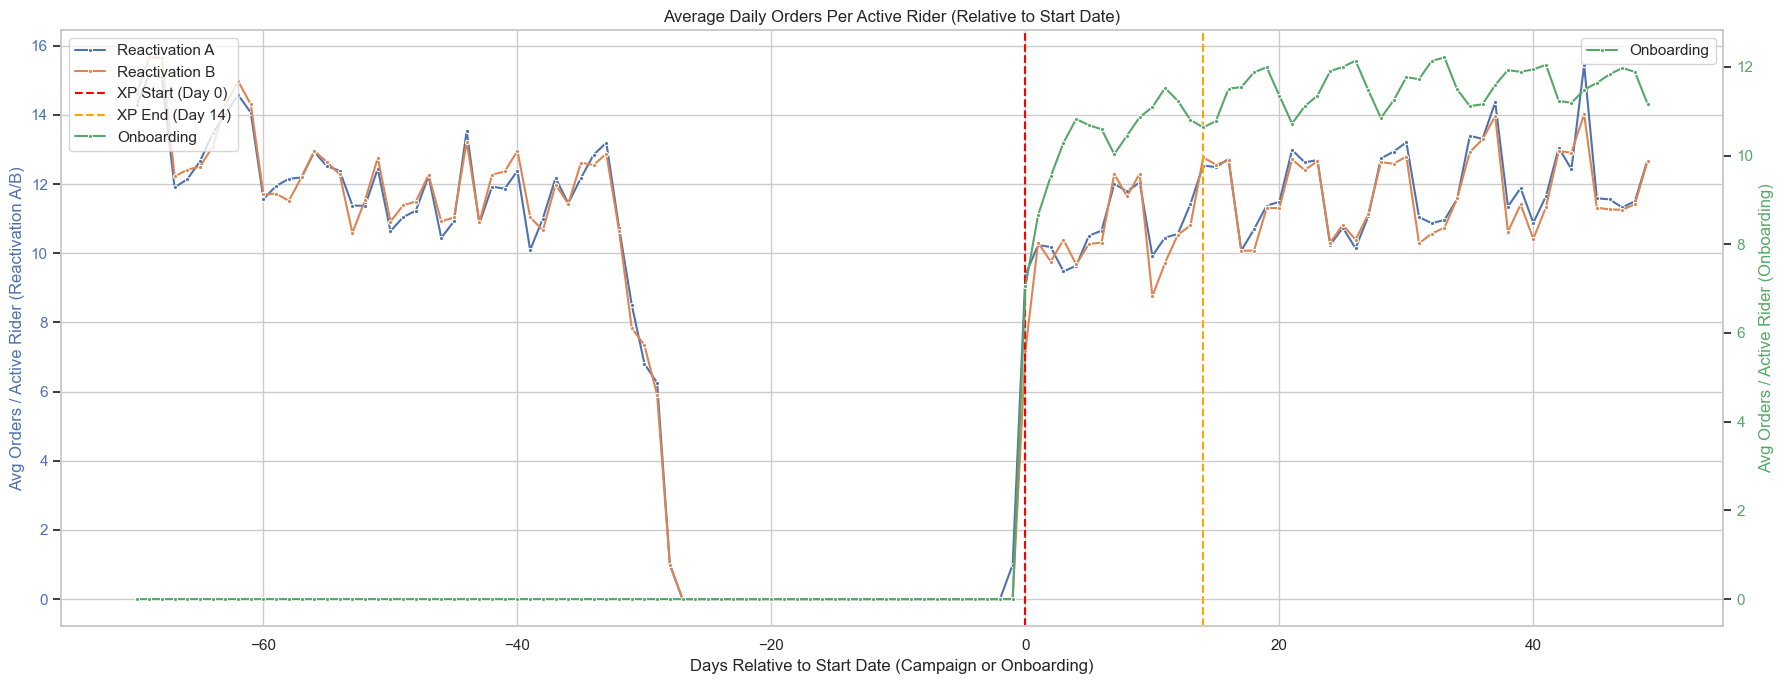

--- Daily Orders Per Active Rider Head (Original Data) ---
        Group  Relative_Day  Orders  Active_Riders  Orders_Per_Active_Rider
0  Onboarding           -70       0            0.0                      0.0
1  Onboarding           -69       0            0.0                      0.0
2  Onboarding           -68       0            0.0                      0.0
3  Onboarding           -67       0            0.0                      0.0
4  Onboarding           -66       0            0.0                      0.0


In [63]:
# --- Step 8 (Corrected): Plot Orders Per Active Rider (Original Data for All Groups) --- 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re # Make sure it's imported

# Check if necessary dataframes exist
if 'daily_orders' not in locals() or 'daily_active_riders' not in locals():
    print("Error: Required DataFrames ('daily_orders', 'daily_active_riders') not found.")
    print("Please ensure the first aggregation cell (Step 2) has been run successfully.")
else:
    # Merge the original aggregated orders and active riders dataframes
    daily_performance_orig = pd.merge(
        daily_orders, 
        daily_active_riders, 
        on=['Group', 'Relative_Day'],
        how='outer'
    ).fillna(0) 

    # --- Calculate Orders Per Active Rider (Original Data) ---
    daily_performance_orig['Orders_Per_Active_Rider'] = np.where(
        daily_performance_orig['Active_Riders'] > 0, 
        daily_performance_orig['Orders'] / daily_performance_orig['Active_Riders'],
        0 
    )

    # --- Plotting Orders Per Active Rider with Dual Y-Axes (Original Data) --- 
    print("Generating Orders Per Active Rider plot...")
    sns.set(style="whitegrid")
    fig, ax1 = plt.subplots(1, 1, figsize=(18, 7)) # Single plot
    ax2 = ax1.twinx() 

    # Get color palette
    palette = sns.color_palette()
    react_a_color = palette[0]
    react_b_color = palette[1]
    onboard_color = palette[2] 

    # Plot Reactivation A and B on ax1 (using original OPAR) - Explicit Labels
    sns.lineplot(data=daily_performance_orig[daily_performance_orig['Group'] == 'Reactivation A'], 
                 x='Relative_Day', y='Orders_Per_Active_Rider', marker='.', ax=ax1, label='Reactivation A', color=react_a_color)
    sns.lineplot(data=daily_performance_orig[daily_performance_orig['Group'] == 'Reactivation B'], 
                 x='Relative_Day', y='Orders_Per_Active_Rider', marker='.', ax=ax1, label='Reactivation B', color=react_b_color)

    # Plot Onboarding on ax2 (using original OPAR) - Explicit Label
    sns.lineplot(data=daily_performance_orig[daily_performance_orig['Group'] == 'Onboarding'], 
                 x='Relative_Day', y='Orders_Per_Active_Rider', marker='.', ax=ax2, label='Onboarding', color=onboard_color) 
                 
    ax1.set_title('Average Daily Orders Per Active Rider (Relative to Start Date)')
    ax1.set_xlabel('Days Relative to Start Date (Campaign or Onboarding)')
    ax1.set_ylabel('Avg Orders / Active Rider (Reactivation A/B)', color=react_a_color)
    ax2.set_ylabel('Avg Orders / Active Rider (Onboarding)', color=onboard_color)
    ax1.tick_params(axis='y', labelcolor=react_a_color)
    ax2.tick_params(axis='y', labelcolor=onboard_color)

    # Add vertical lines
    min_day, max_day = daily_performance_orig['Relative_Day'].min(), daily_performance_orig['Relative_Day'].max()
    vline_handles = {} # Store handles for legend
    if min_day <= 0 <= max_day:
         line_xp_start = ax1.axvline(x=0, color='red', linestyle='--', label='XP Start (Day 0)')
         vline_handles['XP Start (Day 0)'] = line_xp_start
    if min_day <= 14 <= max_day:
         line_xp_end = ax1.axvline(x=14, color='orange', linestyle='--', label='XP End (Day 14)')
         vline_handles['XP End (Day 14)'] = line_xp_end

    # Manually create legends from plotted lines + vlines
    handles = ax1.lines + ax2.lines # Get handles from both axes
    labels = [h.get_label() for h in handles]
    
    # Filter out internal labels starting with '_'
    legend_dict = {label: handle for label, handle in zip(labels, handles) if not label.startswith('_')}
    # Add vlines handles to ensure they appear
    legend_dict.update(vline_handles)

    ax1.legend(legend_dict.values(), legend_dict.keys(), loc='upper left') 
    ax1.grid(True)
    ax2.grid(False) 

    plt.tight_layout()
    plt.show()

    # Display head of the new dataframe for verification
    print("--- Daily Orders Per Active Rider Head (Original Data) ---")
    print(daily_performance_orig[['Group', 'Relative_Day', 'Orders', 'Active_Riders', 'Orders_Per_Active_Rider']].head())

In [64]:
# --- Step 10: All Cities - Generate TSV Output for Order Volume Summary ---

import pandas as pd
import numpy as np 

# Check if df_analysis exists and has been processed
if 'df_analysis' not in locals() or 'Period' not in df_analysis.columns:
    print("Error: 'df_analysis' DataFrame not found or 'Period' column missing.")
    print("Please ensure the previous cell (Step 9) has been run successfully.")
else:
    # --- Recalculate Summary Table (Ensure it's available) ---
    # Filter out any 'Other' periods if necessary 
    df_period_data = df_analysis[df_analysis['Period'] != 'Other'].copy()

    # Group by City, Group, and Period, then sum orders
    grouped_orders = df_period_data.groupby(['CITY', 'Group', 'Period'])['Orders'].sum().reset_index()

    # Pivot the table to have periods as columns
    order_summary_table = pd.pivot_table(
        grouped_orders,
        index=['CITY', 'Group'],
        columns='Period',
        values='Orders',
        fill_value=0 # Fill missing combinations with 0 orders
    )

    # Ensure columns are in logical order (Pre, XP, Post)
    period_order = ['Pre-XP (-70 to -1)', 'XP (0 to 14)', 'Post-XP (15 to 49)']
    order_summary_table = order_summary_table.reindex(columns=period_order, fill_value=0) 

    # Calculate total orders across all periods
    order_summary_table['Total_Orders (All Periods)'] = order_summary_table.sum(axis=1)

    # Sort by the total order volume in descending order
    order_summary_table_sorted = order_summary_table.sort_values(by='Total_Orders (All Periods)', ascending=False)
    
    # Reset index to make CITY and Group regular columns for TSV output
    order_summary_table_sorted.reset_index(inplace=True)

    # --- Generate TSV Output ---
    print("--- ALL CITIES OBOARDS & REACTIVATION  Order Volume Summary (Tab-Separated for Google Sheets) ---")
    print("--- Copy the text below this line ---")
    
    # Output the DataFrame as a tab-separated string, including the header
    tsv_output = order_summary_table_sorted.to_csv(sep='\t', index=False)
    print(tsv_output)
    print("--- End of text to copy ---")


Error: 'df_analysis' DataFrame not found or 'Period' column missing.
Please ensure the previous cell (Step 9) has been run successfully.


In [65]:
# --- Step 11: Summary Table for Reactivation Cities (A vs B) with % Difference ---

import pandas as pd
import numpy as np 

# Check if df_analysis exists and has been processed with 'Group' and 'Period'
if 'df_analysis' not in locals() or 'Group' not in df_analysis.columns or 'Period' not in df_analysis.columns:
    print("Error: 'df_analysis' DataFrame not found or 'Group'/'Period' column missing.")
    print("Please ensure the previous cells (Steps 2 & 9) have been run successfully.")
else:
    # --- Identify Reactivation Cities ---
    reactivation_groups_filter = df_analysis['Group'].str.startswith('Reactivation')
    reactivation_cities = list(df_analysis[reactivation_groups_filter]['CITY'].unique())
    
    if not reactivation_cities:
        print("No cities found with any Reactivation groups.")
    else:
        print(f"Found {len(reactivation_cities)} cities with Reactivation activity.")
        
        # --- Filter Data for Reactivation Groups in these Cities ---
        df_filtered_react = df_analysis[
            df_analysis['CITY'].isin(reactivation_cities) & 
            reactivation_groups_filter &
            (df_analysis['Period'] != 'Other') # Exclude any 'Other' periods
        ].copy()

        # --- Calculate Period Totals ---
        grouped_orders_react = df_filtered_react.groupby(['CITY', 'Group', 'Period'])['Orders'].sum().reset_index()

        # Pivot the table
        order_summary_pivot = pd.pivot_table(
            grouped_orders_react,
            index=['CITY', 'Group'],
            columns='Period',
            values='Orders',
            fill_value=0 
        )

        # Ensure columns are in logical order & add Total
        period_order = ['Pre-XP (-70 to -1)', 'XP (0 to 14)', 'Post-XP (15 to 49)']
        order_summary_pivot = order_summary_pivot.reindex(columns=period_order, fill_value=0) 
        order_summary_pivot['Total_Orders (All Periods)'] = order_summary_pivot.sum(axis=1)

        # --- Calculate % Difference (A vs B) ---
        
        # Unstack to get Group A and B as columns for easy calculation
        order_summary_unstacked = order_summary_pivot.unstack(level='Group')

        # Create a dataframe to store differences
        diff_df = pd.DataFrame(index=order_summary_unstacked.index)

        for period_col in period_order + ['Total_Orders (All Periods)']:
            # Check if both A and B columns exist for the period
            col_a = (period_col, 'Reactivation A')
            col_b = (period_col, 'Reactivation B')
            
            if col_a in order_summary_unstacked.columns and col_b in order_summary_unstacked.columns:
                orders_a = order_summary_unstacked[col_a]
                orders_b = order_summary_unstacked[col_b]
                
                # Calculate percentage difference, handle division by zero
                diff_df[period_col] = np.where(
                    orders_b != 0, 
                    (orders_a - orders_b) / orders_b, 
                    np.nan # Assign NaN if B is zero
                ) 
            else:
                 # If one group is missing for a city, diff cannot be calculated
                 diff_df[period_col] = np.nan 

        diff_df['Group'] = '% Diff (A vs B)'
        diff_df.reset_index(inplace=True) # Move CITY from index to column
        diff_df.set_index(['CITY', 'Group'], inplace=True) # Set multi-index like the pivot table

        # --- Combine and Sort ---
        
        # Concatenate the original pivot table with the difference data
        final_summary_table = pd.concat([order_summary_pivot, diff_df])

        # Define custom sort order for Group
        group_order = ['Reactivation A', 'Reactivation B', '% Diff (A vs B)']
        final_summary_table.reset_index(inplace=True)
        final_summary_table['Group'] = pd.Categorical(final_summary_table['Group'], categories=group_order, ordered=True)
        
        # Sort by CITY ascending, then by the custom Group order
        final_summary_table_sorted = final_summary_table.sort_values(by=['CITY', 'Group'])

        # --- Generate TSV Output ---
        print("\n--- Filtered Reactivation Order Summary (A vs B with % Diff - Tab-Separated) ---")
        print("--- Copy the text below this line ---")
        
        # Output the DataFrame as a tab-separated string
        # Format percentages and handle NaNs in output
        tsv_output = final_summary_table_sorted.to_csv(
            sep='\t', 
            index=False, 
            float_format='%.2f', # Format floats (like percentages)
            na_rep='N/A' # Represent NaN values as N/A
        )
        # Manually format the percentage rows for better readability in TSV
        lines = tsv_output.splitlines()
        formatted_lines = [lines[0]] # Keep header
        for line in lines[1:]:
            parts = line.split('\t')
            if parts[1] == '% Diff (A vs B)': # Check if it's a percentage row
                # Format numerical columns (index 2 onwards) as percentages
                 formatted_parts = [parts[0], parts[1]] + \
                                   [f"{float(p)*100:.1f}%" if p != 'N/A' else 'N/A' for p in parts[2:]]
                 formatted_lines.append('\t'.join(formatted_parts))
            else:
                 # Keep non-percentage rows as is (integers for counts)
                 formatted_parts = [parts[0], parts[1]] + \
                                   [f"{float(p):.0f}" if p != 'N/A' else 'N/A' for p in parts[2:]]
                 formatted_lines.append('\t'.join(formatted_parts))

        print('\n'.join(formatted_lines))
        print("--- End of text to copy ---")

Error: 'df_analysis' DataFrame not found or 'Group'/'Period' column missing.
Please ensure the previous cells (Steps 2 & 9) have been run successfully.


--- Generating Vehicle Type Proportion Chart ---


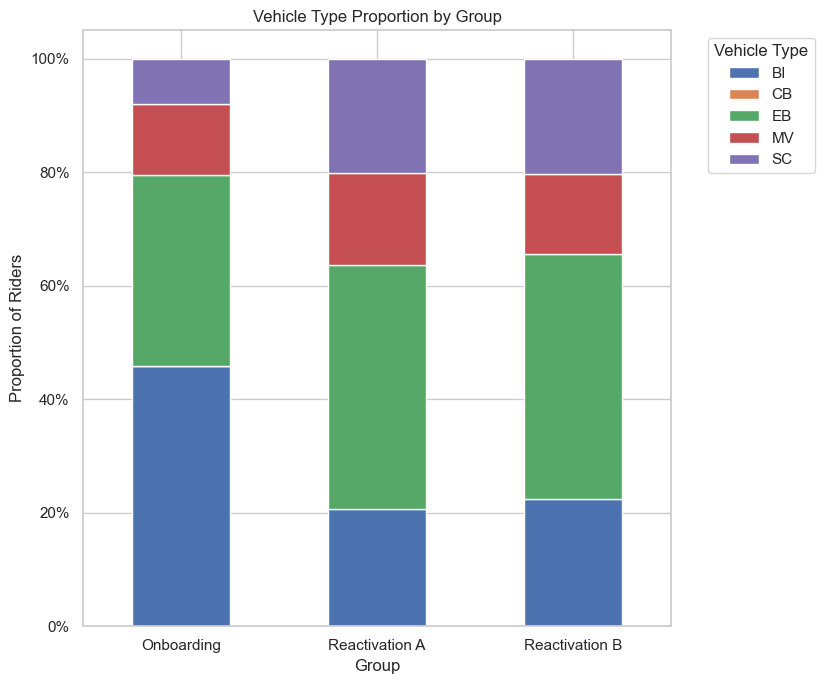


--- Vehicle Type Proportions ---
VEHICLE_TYPE       BI    CB     EB     MV     SC
Group                                           
Onboarding      45.9%  0.0%  33.6%  12.5%   8.1%
Reactivation A  20.7%  0.0%  42.9%  16.3%  20.1%
Reactivation B  22.5%  0.0%  43.1%  14.1%  20.3%


In [66]:
# --- Step 13: Plot Vehicle Type Proportions by Group ---

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For formatting y-axis as percentage
import seaborn as sns 

# Check if df2 exists
if 'df2' not in locals():
    print("Error: 'df2' DataFrame not found.")
    print("Please ensure the first cell loading data has been run successfully.")
else:
    # --- Prepare Data ---
    # Ensure VEHICLE_TYPE column exists
    if 'VEHICLE_TYPE' not in df2.columns:
         print("Error: 'VEHICLE_TYPE' column not found in df2.")
    else:
        # Define function to assign combined group (consistent with previous steps)
        def assign_group_orig(row):
            source = row.get('SOURCE', None)
            group_fixed = row.get('GROUP_FIXED', None) 
            if source == 'Onboarding':
                return 'Onboarding'
            elif source == 'Reactivation':
                if group_fixed == 'A':
                    return 'Reactivation A'
                elif group_fixed == 'B':
                    return 'Reactivation B'
            return 'Other'
            
        # Create the 'Group' column in df2 (make a copy to avoid modifying original)
        df2_with_group = df2.copy()
        df2_with_group['Group'] = df2_with_group.apply(assign_group_orig, axis=1)
        
        # Filter out any 'Other' groups if necessary
        df_plot_data = df2_with_group[df2_with_group['Group'] != 'Other'].copy()

        # --- Calculate Proportions ---
        
        # Count unique riders per Group and Vehicle Type
        vehicle_counts = df_plot_data.groupby(['Group', 'VEHICLE_TYPE'])['DRIVER_ID'].nunique().reset_index()
        vehicle_counts.rename(columns={'DRIVER_ID': 'Rider_Count'}, inplace=True)
        
        # Calculate total riders per Group
        total_riders_per_group = vehicle_counts.groupby('Group')['Rider_Count'].sum()
        
        # Calculate proportion
        vehicle_proportions = vehicle_counts.set_index('Group')
        vehicle_proportions['Proportion'] = vehicle_proportions['Rider_Count'] / total_riders_per_group
        vehicle_proportions.reset_index(inplace=True)

        # --- Plotting ---
        
        # Pivot table for plotting
        vehicle_pivot = pd.pivot_table(
            vehicle_proportions,
            index='Group',
            columns='VEHICLE_TYPE',
            values='Proportion',
            fill_value=0
        )
        
        # Ensure a consistent order for plotting if needed
        # vehicle_pivot = vehicle_pivot[['BI', 'EB', 'MV', 'SC']] # Adjust if needed

        print("--- Generating Vehicle Type Proportion Chart ---")
        sns.set(style="whitegrid")
        ax = vehicle_pivot.plot(kind='bar', stacked=True, figsize=(10, 7))

        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

        plt.title('Vehicle Type Proportion by Group')
        plt.xlabel('Group')
        plt.ylabel('Proportion of Riders')
        plt.xticks(rotation=0) # Keep x-axis labels horizontal
        plt.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.show()

        # Display the proportion table for reference
        print("\n--- Vehicle Type Proportions ---")
        # Format proportion column as percentage for display
        vehicle_pivot_display = vehicle_pivot.copy()
        for col in vehicle_pivot_display.columns:
             vehicle_pivot_display[col] = vehicle_pivot_display[col].map('{:.1%}'.format)
        print(vehicle_pivot_display.to_string())

Adding 'Period' column to df_analysis...
Calculating active rider proportions...
Calculating order volume proportions...
Generating Vehicle Type Proportion Charts (Days 0-49) ---


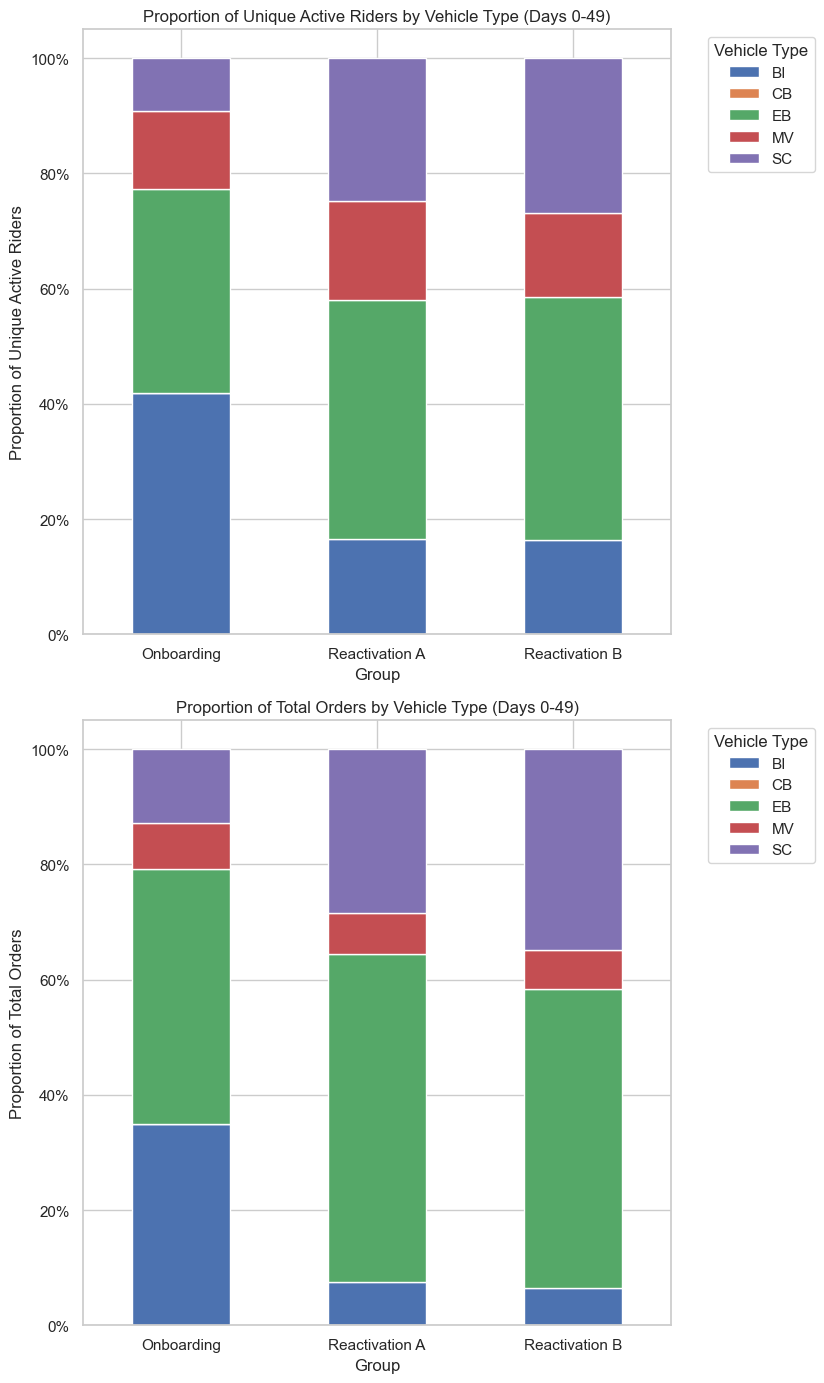


--- Unique Active Rider Proportions (Days 0-49) ---
VEHICLE_TYPE       BI    CB     EB     MV     SC
Group                                           
Onboarding      41.8%  0.0%  35.4%  13.5%   9.2%
Reactivation A  16.5%  0.0%  41.5%  17.2%  24.8%
Reactivation B  16.3%  0.0%  42.2%  14.6%  26.9%

--- Order Volume Proportions (Days 0-49) ---
VEHICLE_TYPE       BI    CB     EB    MV     SC
Group                                          
Onboarding      35.0%  0.0%  44.2%  8.1%  12.8%
Reactivation A   7.5%  0.0%  57.0%  7.1%  28.4%
Reactivation B   6.5%  0.0%  51.9%  6.8%  34.9%


In [67]:
# --- Step 14 (Revised): Plot Active Rider and Order Proportions by Vehicle Type (Days 0-49) ---

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For formatting y-axis as percentage
import seaborn as sns 
import re # Make sure it's imported

# Check if df_analysis exists and has required columns
if 'df_analysis' not in locals() or 'Group' not in df_analysis.columns or 'Relative_Day' not in df_analysis.columns or 'VEHICLE_TYPE' not in df_analysis.columns:
    print("Error: 'df_analysis' DataFrame not found or key columns missing.")
    print("Please ensure the cell creating df_analysis (Step 2) has been run successfully.")
else:
    # --- Add Period Column (Logic from deleted Step 9) ---
    print("Adding 'Period' column to df_analysis...")
    
    def assign_period(day):
        if day < 0:
            return 'Pre-XP (-70 to -1)'
        elif 0 <= day <= 14:
            return 'XP (0 to 14)'
        elif 15 <= day <= 49: # Matching the Post-XP definition used before
            return 'Post-XP (15 to 49)'
        else:
            # Include days beyond 49 in 'Other' for this calculation if they exist
            return 'Other' 
            
    df_analysis['Period'] = df_analysis['Relative_Day'].apply(assign_period)
    
    # --- Filter Data for XP and Post-XP Period Combined (Days 0-49) ---
    # Filter based on the newly created 'Period' column
    analysis_period_filter = (df_analysis['Period'] == 'XP (0 to 14)') | (df_analysis['Period'] == 'Post-XP (15 to 49)')
    df_period_analysis = df_analysis[analysis_period_filter].copy()

    if df_period_analysis.empty:
        print("No data found for the period Days 0-49.")
    else:
        # --- 1. Active Rider Proportions ---
        print("Calculating active rider proportions...")
        # Filter for riders active during the period
        active_riders_period = df_period_analysis[df_period_analysis['Orders'] > 0]
        
        # Count unique active riders per Group and Vehicle Type
        active_vehicle_counts = active_riders_period.groupby(['Group', 'VEHICLE_TYPE'])['DRIVER_ID'].nunique().reset_index()
        active_vehicle_counts.rename(columns={'DRIVER_ID': 'Unique_Active_Riders'}, inplace=True)
        
        # Calculate total unique active riders per Group
        total_active_per_group = active_vehicle_counts.groupby('Group')['Unique_Active_Riders'].sum()
        
        # Calculate proportion
        active_vehicle_proportions = active_vehicle_counts.set_index('Group')
        # Use .div() with level=0 for robust division by group totals, fillna(0)
        active_vehicle_proportions['Proportion'] = active_vehicle_proportions['Unique_Active_Riders'].div(total_active_per_group, level=0).fillna(0)
        active_vehicle_proportions.reset_index(inplace=True)

        # Pivot for plotting
        active_vehicle_pivot = pd.pivot_table(
            active_vehicle_proportions,
            index='Group',
            columns='VEHICLE_TYPE',
            values='Proportion',
            fill_value=0
        )
        
        # --- 2. Order Volume Proportions ---
        print("Calculating order volume proportions...")
        # Sum orders per Group and Vehicle Type
        order_vehicle_totals = df_period_analysis.groupby(['Group', 'VEHICLE_TYPE'])['Orders'].sum().reset_index()
        
        # Calculate total orders per Group
        total_orders_per_group = order_vehicle_totals.groupby('Group')['Orders'].sum()
        
        # Calculate proportion
        order_vehicle_proportions = order_vehicle_totals.set_index('Group')
        # Use .div() with level=0 for robust division, fillna(0)
        order_vehicle_proportions['Proportion'] = order_vehicle_proportions['Orders'].div(total_orders_per_group, level=0).fillna(0)
        order_vehicle_proportions.reset_index(inplace=True)

        # Pivot for plotting
        order_vehicle_pivot = pd.pivot_table(
            order_vehicle_proportions,
            index='Group',
            columns='VEHICLE_TYPE',
            values='Proportion',
            fill_value=0
        )

        # --- Plotting ---
        print("Generating Vehicle Type Proportion Charts (Days 0-49) ---")
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(10, 14)) # Two plots vertically

        # Plot 1: Active Rider Proportions
        if not active_vehicle_pivot.empty:
            active_vehicle_pivot.plot(kind='bar', stacked=True, ax=axes[0])
            axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
            axes[0].set_title('Proportion of Unique Active Riders by Vehicle Type (Days 0-49)')
            axes[0].set_xlabel('Group')
            axes[0].set_ylabel('Proportion of Unique Active Riders')
            axes[0].tick_params(axis='x', rotation=0)
            axes[0].legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            axes[0].text(0.5, 0.5, 'No active rider data to plot', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
            axes[0].set_title('Proportion of Unique Active Riders by Vehicle Type (Days 0-49)')


        # Plot 2: Order Volume Proportions
        if not order_vehicle_pivot.empty:
            order_vehicle_pivot.plot(kind='bar', stacked=True, ax=axes[1])
            axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
            axes[1].set_title('Proportion of Total Orders by Vehicle Type (Days 0-49)')
            axes[1].set_xlabel('Group')
            axes[1].set_ylabel('Proportion of Total Orders')
            axes[1].tick_params(axis='x', rotation=0)
            axes[1].legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
             axes[1].text(0.5, 0.5, 'No order data to plot', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
             axes[1].set_title('Proportion of Total Orders by Vehicle Type (Days 0-49)')


        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legends
        plt.show()

        # Display proportion tables for reference
        if not active_vehicle_pivot.empty:
            print("\n--- Unique Active Rider Proportions (Days 0-49) ---")
            active_vehicle_pivot_display = active_vehicle_pivot.copy()
            for col in active_vehicle_pivot_display.columns:
                 active_vehicle_pivot_display[col] = active_vehicle_pivot_display[col].map('{:.1%}'.format)
            print(active_vehicle_pivot_display.to_string())
        
        if not order_vehicle_pivot.empty:
            print("\n--- Order Volume Proportions (Days 0-49) ---")
            order_vehicle_pivot_display = order_vehicle_pivot.copy()
            for col in order_vehicle_pivot_display.columns:
                 order_vehicle_pivot_display[col] = order_vehicle_pivot_display[col].map('{:.1%}'.format)
            print(order_vehicle_pivot_display.to_string())


In [71]:
# --- Step 16: Calculate Incremental Cost Per Order & Per Avg Daily Rider (Using Normalized A) ---

import pandas as pd
import numpy as np 

# --- Prerequisites ---
# Ensure relevant dataframes exist from previous steps
if 'total_cost_a' not in locals():
    print("Error: total_cost_a not found. Please run the cell that calculates it.")
elif 'daily_orders_norm' not in locals() or 'daily_active_riders_norm' not in locals():
     print("Error: Normalized daily dataframes ('daily_orders_norm', 'daily_active_riders_norm') not found.")
     print("Please ensure the cell calculating normalization (Step 3 or equivalent) has run.")
elif 'df_analysis' not in locals() or 'Group' not in df_analysis.columns or 'Relative_Day' not in df_analysis.columns:
    print("Error: 'df_analysis' DataFrame not found or key columns missing.")
    print("Please ensure the cell creating df_analysis (Step 2) has run.")
else:
    onboarding_cost_per_rider = 100 # As specified

    # --- Define Period Filters (on normalized daily data) ---
    pre_xp_filter_orders = (daily_orders_norm['Relative_Day'] < 0)
    xp_period_filter_orders = (daily_orders_norm['Relative_Day'] >= 0) & (daily_orders_norm['Relative_Day'] <= 14)
    post_xp_period_filter_orders = (daily_orders_norm['Relative_Day'] >= 15) & (daily_orders_norm['Relative_Day'] <= 49)
    combined_period_filter_orders = (daily_orders_norm['Relative_Day'] >= 0) & (daily_orders_norm['Relative_Day'] <= 49) # For onboarding totals
    
    pre_xp_filter_active = (daily_active_riders_norm['Relative_Day'] < 0)
    xp_period_filter_active = (daily_active_riders_norm['Relative_Day'] >= 0) & (daily_active_riders_norm['Relative_Day'] <= 14)
    post_xp_period_filter_active = (daily_active_riders_norm['Relative_Day'] >= 15) & (daily_active_riders_norm['Relative_Day'] <= 49)
    combined_period_filter_active = (daily_active_riders_norm['Relative_Day'] >= 0) & (daily_active_riders_norm['Relative_Day'] <= 49) # For onboarding totals
    
    # Define period filters for the non-aggregated data (df_analysis) - needed for onboarding unique riders
    pre_xp_period_filter_analysis = (df_analysis['Relative_Day'] < 0)
    xp_period_filter_analysis = (df_analysis['Relative_Day'] >= 0) & (df_analysis['Relative_Day'] <= 14)
    post_xp_period_filter_analysis = (df_analysis['Relative_Day'] >= 15) & (df_analysis['Relative_Day'] <= 49)
    combined_period_filter_analysis = (df_analysis['Relative_Day'] >= 0) & (df_analysis['Relative_Day'] <= 49)

    # --- Calculate Period Totals and Averages ---
    
    periods = {
        "Pre-XP (-70 to -1)": (pre_xp_filter_orders, pre_xp_filter_active, pre_xp_period_filter_analysis),
        "XP (0-14)": (xp_period_filter_orders, xp_period_filter_active, xp_period_filter_analysis),
        "Post-XP (15-49)": (post_xp_period_filter_orders, post_xp_period_filter_active, post_xp_period_filter_analysis),
        "Combined (0-49)": (combined_period_filter_orders, combined_period_filter_active, combined_period_filter_analysis)
    }
    
    results = {}
    
    for period_name, (p_filter_ord, p_filter_act, p_filter_analysis) in periods.items():
        
        # --- Reactivation A (Normalized) ---
        orders_a_norm_period = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation A') & p_filter_ord]
        active_a_norm_period = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation A') & p_filter_act]
        
        avg_orders_a_norm = orders_a_norm_period['Orders_Normalized'].mean() if not orders_a_norm_period.empty else 0
        total_orders_a_norm = orders_a_norm_period['Orders_Normalized'].sum()
        avg_active_a_norm = active_a_norm_period['Active_Riders_Normalized'].mean() if not active_a_norm_period.empty else 0
        # Total Unique Active Riders for A (Raw count needed for context, not normalized total)
        riders_a_unique_period_df = df_analysis[(df_analysis['Group'] == 'Reactivation A') & (df_analysis['Orders'] > 0) & p_filter_analysis]
        total_riders_a_unique = riders_a_unique_period_df['DRIVER_ID'].nunique() if not riders_a_unique_period_df.empty else 0

        # --- Reactivation B (Original) ---
        orders_b_period = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation B') & p_filter_ord]
        active_b_period = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation B') & p_filter_act]

        avg_orders_b = orders_b_period['Orders'].mean() if not orders_b_period.empty else 0
        total_orders_b = orders_b_period['Orders'].sum()
        avg_active_b = active_b_period['Active_Riders'].mean() if not active_b_period.empty else 0
        # Total Unique Active Riders for B
        riders_b_unique_period_df = df_analysis[(df_analysis['Group'] == 'Reactivation B') & (df_analysis['Orders'] > 0) & p_filter_analysis]
        total_riders_b_unique = riders_b_unique_period_df['DRIVER_ID'].nunique() if not riders_b_unique_period_df.empty else 0

        # --- Onboarding ---
        orders_onboard_period = daily_orders_norm[(daily_orders_norm['Group'] == 'Onboarding') & p_filter_ord]
        active_onboard_period = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Onboarding') & p_filter_act]

        total_orders_onboard = orders_onboard_period['Orders'].sum()
        # Total Unique Active Riders for Onboarding
        riders_onboard_unique_period_df = df_analysis[(df_analysis['Group'] == 'Onboarding') & (df_analysis['Orders'] > 0) & p_filter_analysis]
        total_riders_onboard_unique = riders_onboard_unique_period_df['DRIVER_ID'].nunique() if not riders_onboard_unique_period_df.empty else 0

        # --- Store results ---
        results[period_name] = {
            'Avg_Orders_A_Norm': avg_orders_a_norm,
            'Avg_Orders_B': avg_orders_b,
            'Total_Orders_A_Norm': total_orders_a_norm,
            'Total_Orders_B': total_orders_b,
            'Avg_Active_A_Norm': avg_active_a_norm,
            'Avg_Active_B': avg_active_b,
            'Total_Riders_A_Unique': total_riders_a_unique, # Raw count
            'Total_Riders_B_Unique': total_riders_b_unique, # Raw count
            'Total_Orders_Onboard': total_orders_onboard,
            'Total_Riders_Onboard_Unique': total_riders_onboard_unique
        }

    # --- Calculate Incremental Metrics and Costs ---
    
    print("--- Incremental Cost Analysis (Using Normalized Group A Averages for CPAR) ---")
    print(f"Total Incentive Cost for Group A: £{total_cost_a}\n")
    print(f"{'Period':<20} | {'Incr. Orders (A_norm-B)':<25} | {'CPIO (A_norm vs B)':<20} | {'Incr. Avg Daily Riders (A_norm-B)':<30} | {'CPAR (A_norm vs B - Avg Daily)':<25}")
    print("-" * 125)

    summary_metrics = {}

    for period_name in ["Pre-XP (-70 to -1)", "XP (0-14)", "Post-XP (15-49)", "Combined (0-49)"]:
        period_res = results[period_name]
        
        incr_orders_total = period_res['Total_Orders_A_Norm'] - period_res['Total_Orders_B']
        incr_riders_avg_daily = period_res['Avg_Active_A_Norm'] - period_res['Avg_Active_B']
        
        # Calculate CPIO (Cost Per Incremental Order) - Use Total Incremental Orders
        # Cost only applies during/after XP
        current_cost = total_cost_a if period_name != "Pre-XP (-70 to -1)" else 0
        cpio = current_cost / incr_orders_total if incr_orders_total > 0 else np.nan
        
        # Calculate CPAR (Cost Per Incremental *Average Daily* Active Rider) 
        cpar = current_cost / incr_riders_avg_daily if incr_riders_avg_daily > 0 else np.nan

        summary_metrics[period_name] = {'cpio': cpio, 'cpar': cpar} # Store for final comparison

        print(f"{period_name:<20} | {incr_orders_total:<25.0f} | £{cpio:<18.2f} | {incr_riders_avg_daily:<30.2f} | £{cpar:<23.2f}")

    # --- Onboarding Cost Comparison (Calculated per period now) ---
    print("\n--- Onboarding Cost Comparison ---")
    print(f"Assumed Onboarding Cost per Rider: £{onboarding_cost_per_rider}")
    print(f"\n{'Period':<20} | {'Total Onboard Riders':<20} | {'Total Onboard Orders':<20} | {'Total Onboard Cost':<20} | {'CPO (Onboard)':<15} | {'CPAR (Onboard)':<15}")
    print("-" * 115)
    
    onboarding_costs = {}
    for period_name in ["Pre-XP (-70 to -1)", "XP (0-14)", "Post-XP (15-49)", "Combined (0-49)"]:
         period_res = results[period_name]
         total_onboards_unique = period_res['Total_Riders_Onboard_Unique']
         total_orders_onboard = period_res['Total_Orders_Onboard']
         # Cost is per unique rider active in the period, using the fixed onboarding cost
         total_onboarding_cost = total_onboards_unique * onboarding_cost_per_rider 
         cpo_onboard = total_onboarding_cost / total_orders_onboard if total_orders_onboard > 0 else np.nan
         cpar_onboard = onboarding_cost_per_rider if total_onboards_unique > 0 else np.nan # Cost per rider is fixed
         
         onboarding_costs[period_name] = {'cpo': cpo_onboard, 'cpar': cpar_onboard} # Store for final comparison

         print(f"{period_name:<20} | {total_onboards_unique:<20} | {total_orders_onboard:<20} | £{total_onboarding_cost:<18.0f} | £{cpo_onboard:<13.2f} | £{cpar_onboard:<13.2f}")
         

    # --- Summary Comparison Table ---
    print("\n--- Summary Cost Comparison ---")
    print(f"{'Period':<20} | {'CPIO (A_norm vs B)':<20} | {'CPO (Onboard)':<15} | {'CPAR (A_norm vs B - Avg Daily)':<30} | {'CPAR (Onboard)':<15}")
    print("-" * 110)
    for period_name in ["Pre-XP (-70 to -1)", "XP (0-14)", "Post-XP (15-49)", "Combined (0-49)"]:
        print(f"{period_name:<20} | £{summary_metrics[period_name]['cpio']:<18.2f} | £{onboarding_costs[period_name]['cpo']:<13.2f} | £{summary_metrics[period_name]['cpar']:<28.2f} | £{onboarding_costs[period_name]['cpar']:<13.2f}")


--- Incremental Cost Analysis (Using Normalized Group A Averages for CPAR) ---
Total Incentive Cost for Group A: £51280

Period               | Incr. Orders (A_norm-B)   | CPIO (A_norm vs B)   | Incr. Avg Daily Riders (A_norm-B) | CPAR (A_norm vs B - Avg Daily)
-----------------------------------------------------------------------------------------------------------------------------
Pre-XP (-70 to -1)   | 0                         | £0.00               | -0.00                          | £nan                    
XP (0-14)            | 10513                     | £4.88               | 62.64                          | £818.66                 
Post-XP (15-49)      | 20910                     | £2.45               | 47.46                          | £1080.49                
Combined (0-49)      | 31423                     | £1.63               | 52.01                          | £985.90                 

--- Onboarding Cost Comparison ---
Assumed Onboarding Cost per Rider: £100

Period     

In [77]:
# --- Step 17: Comprehensive Summary Table for GSheets (A Norm vs B, Onboarding) ---

import pandas as pd
import numpy as np 

# --- Prerequisites ---
# Ensure relevant dataframes and variables exist
required_vars = ['total_cost_a', 'daily_orders_norm', 'daily_active_riders_norm', 'df_analysis']
if not all(var in locals() for var in required_vars):
    print("Error: One or more required variables/dataframes not found.")
    print("Please ensure cells for Step 2 (or recreation), Step 3 (normalization), and cost calculation have run.")
elif 'Group' not in df_analysis.columns or 'Relative_Day' not in df_analysis.columns:
     print("Error: df_analysis DataFrame missing 'Group' or 'Relative_Day'. Please re-run Step 2.")
else:
    onboarding_cost_per_rider = 100 # As specified

    # --- Define Period Filters (on _norm and _analysis dfs) ---
    period_filters = {
        "Pre-XP (-70 to -1)": {
            "ord": (daily_orders_norm['Relative_Day'] < 0),
            "act": (daily_active_riders_norm['Relative_Day'] < 0),
            "anl": (df_analysis['Relative_Day'] < 0)
        },
        "XP (0-14)": {
            "ord": (daily_orders_norm['Relative_Day'] >= 0) & (daily_orders_norm['Relative_Day'] <= 14),
            "act": (daily_active_riders_norm['Relative_Day'] >= 0) & (daily_active_riders_norm['Relative_Day'] <= 14),
            "anl": (df_analysis['Relative_Day'] >= 0) & (df_analysis['Relative_Day'] <= 14)
        },
        "Post-XP (15-49)": {
            "ord": (daily_orders_norm['Relative_Day'] >= 15) & (daily_orders_norm['Relative_Day'] <= 49),
            "act": (daily_active_riders_norm['Relative_Day'] >= 15) & (daily_active_riders_norm['Relative_Day'] <= 49),
            "anl": (df_analysis['Relative_Day'] >= 15) & (df_analysis['Relative_Day'] <= 49)
        },
        "Combined (0-49)": {
            "ord": (daily_orders_norm['Relative_Day'] >= 0) & (daily_orders_norm['Relative_Day'] <= 49),
            "act": (daily_active_riders_norm['Relative_Day'] >= 0) & (daily_active_riders_norm['Relative_Day'] <= 49),
            "anl": (df_analysis['Relative_Day'] >= 0) & (df_analysis['Relative_Day'] <= 49)
        }
    }
    
    # --- Calculate All Metrics per Period ---
    
    period_summary_list = []
    
    for period_name, filters in period_filters.items():
        
        p_filter_ord = filters["ord"]
        p_filter_act = filters["act"]
        p_filter_anl = filters["anl"]
        
        # --- Filter data for the period ---
        orders_a_norm_period = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation A') & p_filter_ord]
        active_a_norm_period = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation A') & p_filter_act]
        orders_b_period = daily_orders_norm[(daily_orders_norm['Group'] == 'Reactivation B') & p_filter_ord]
        active_b_period = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Reactivation B') & p_filter_act]
        orders_onboard_period = daily_orders_norm[(daily_orders_norm['Group'] == 'Onboarding') & p_filter_ord]
        active_onboard_period = daily_active_riders_norm[(daily_active_riders_norm['Group'] == 'Onboarding') & p_filter_act]
        analysis_period_data = df_analysis[p_filter_anl] # For unique rider counts

        # --- Calculate Averages ---
        avg_orders_a_norm = orders_a_norm_period['Orders_Normalized'].mean() if not orders_a_norm_period.empty else 0
        avg_orders_b = orders_b_period['Orders'].mean() if not orders_b_period.empty else 0
        avg_orders_onboard = orders_onboard_period['Orders'].mean() if not orders_onboard_period.empty else 0
        
        avg_active_a_norm = active_a_norm_period['Active_Riders_Normalized'].mean() if not active_a_norm_period.empty else 0
        avg_active_b = active_b_period['Active_Riders'].mean() if not active_b_period.empty else 0
        avg_active_onboard = active_onboard_period['Active_Riders'].mean() if not active_onboard_period.empty else 0

        # --- Calculate Totals ---
        total_orders_a_norm = orders_a_norm_period['Orders_Normalized'].sum()
        total_orders_b = orders_b_period['Orders'].sum()
        total_orders_onboard = orders_onboard_period['Orders'].sum()
        
        riders_a_unique_df = analysis_period_data[(analysis_period_data['Group'] == 'Reactivation A') & (analysis_period_data['Orders'] > 0)]
        total_riders_a_unique = riders_a_unique_df['DRIVER_ID'].nunique() if not riders_a_unique_df.empty else 0
        riders_b_unique_df = analysis_period_data[(analysis_period_data['Group'] == 'Reactivation B') & (analysis_period_data['Orders'] > 0)]
        total_riders_b_unique = riders_b_unique_df['DRIVER_ID'].nunique() if not riders_b_unique_df.empty else 0
        riders_onboard_unique_df = analysis_period_data[(analysis_period_data['Group'] == 'Onboarding') & (analysis_period_data['Orders'] > 0)]
        total_riders_onboard_unique = riders_onboard_unique_df['DRIVER_ID'].nunique() if not riders_onboard_unique_df.empty else 0

        # --- Calculate Incremental & Uplift (A norm vs B) ---
        incr_orders_total = total_orders_a_norm - total_orders_b
        incr_riders_avg_daily = avg_active_a_norm - avg_active_b
        
        uplift_orders_total = (total_orders_a_norm / total_orders_b - 1) if total_orders_b != 0 else np.nan
        uplift_orders_avg = (avg_orders_a_norm / avg_orders_b - 1) if avg_orders_b != 0 else np.nan
        uplift_riders_unique = (total_riders_a_unique / total_riders_b_unique - 1) if total_riders_b_unique != 0 else np.nan # Raw vs Raw
        uplift_riders_avg = (avg_active_a_norm / avg_active_b - 1) if avg_active_b != 0 else np.nan

        # --- Calculate Costs ---
        current_incentive_cost = total_cost_a if period_name != "Pre-XP (-70 to -1)" else 0 # Cost applies only for XP onwards periods
        cpio_a_vs_b = current_incentive_cost / incr_orders_total if incr_orders_total > 0 else np.nan
        cpar_a_vs_b_avg = current_incentive_cost / incr_riders_avg_daily if incr_riders_avg_daily > 0 else np.nan
        
        total_onboarding_cost = total_riders_onboard_unique * onboarding_cost_per_rider
        cpo_onboard = total_onboarding_cost / total_orders_onboard if total_orders_onboard > 0 else np.nan
        cpar_onboard = onboarding_cost_per_rider if total_riders_onboard_unique > 0 else np.nan

        # --- Store in dictionary ---
        period_summary_list.append({
            'Period': period_name,
            'Total Orders A (Norm)': total_orders_a_norm,
            'Total Orders B': total_orders_b,
            'Total Orders Onboard': total_orders_onboard,
            'Avg Daily Orders A (Norm)': avg_orders_a_norm,
            'Avg Daily Orders B': avg_orders_b,
            'Avg Daily Orders Onboard': avg_orders_onboard,
            'Total Unique Riders A': total_riders_a_unique, # Raw count
            'Total Unique Riders B': total_riders_b_unique, # Raw count
            'Total Unique Riders Onboard': total_riders_onboard_unique,
            'Avg Daily Riders A (Norm)': avg_active_a_norm,
            'Avg Daily Riders B': avg_active_b,
            'Avg Daily Riders Onboard': avg_active_onboard,
            '% Uplift Orders (Total, A_norm vs B)': uplift_orders_total,
            '% Uplift Orders (Avg, A_norm vs B)': uplift_orders_avg,
            '% Uplift Riders (Unique, A vs B)': uplift_riders_unique, # Raw vs Raw
            '% Uplift Riders (Avg, A_norm vs B)': uplift_riders_avg,
            'CPIO (A_norm vs B)': cpio_a_vs_b,
            'CPAR (A_norm vs B - Avg Daily)': cpar_a_vs_b_avg,
            'CPO (Onboard)': cpo_onboard,
            'CPAR (Onboard)': cpar_onboard,
            'Incr. Orders (Total, A_norm - B)': incr_orders_total, # Add raw incrementals too
            'Incr. Riders (Avg Daily, A_norm - B)': incr_riders_avg_daily 
        })

    # --- Create Final DataFrame ---
    summary_df = pd.DataFrame(period_summary_list)
    summary_df.set_index('Period', inplace=True)
    # Reorder columns for better readability if desired
    col_order = [
        # Totals
        'Total Orders A (Norm)', 'Total Orders B', 'Total Orders Onboard',
        'Total Unique Riders A', 'Total Unique Riders B', 'Total Unique Riders Onboard',
        # Averages
        'Avg Daily Orders A (Norm)', 'Avg Daily Orders B', 'Avg Daily Orders Onboard',
        'Avg Daily Riders A (Norm)', 'Avg Daily Riders B', 'Avg Daily Riders Onboard',
        # Incremental & Uplift A vs B
        'Incr. Orders (Total, A_norm - B)', '% Uplift Orders (Total, A_norm vs B)', 
        'Incr. Riders (Avg Daily, A_norm - B)', '% Uplift Riders (Avg, A_norm vs B)', 
        '% Uplift Riders (Unique, A vs B)', 
        # Costs
        'CPIO (A_norm vs B)', 'CPAR (A_norm vs B - Avg Daily)',
        'CPO (Onboard)', 'CPAR (Onboard)'
    ]
    summary_df = summary_df[col_order]

    # --- Format and Generate TSV Output ---
    print("--- Comprehensive Summary Table (Tab-Separated for Google Sheets) ---")
    print("--- Copy the text below this line ---")

    # Prepare a copy for formatting
    summary_df_formatted = summary_df.copy()

    # Format percentage columns
    perc_cols = [col for col in summary_df.columns if '% Uplift' in col]
    for col in perc_cols:
        summary_df_formatted[col] = summary_df_formatted[col].map('{:.1%}'.format, na_action='ignore')
    
    # Format cost columns (e.g., CPIO, CPAR)
    cost_cols = [col for col in summary_df.columns if 'CPIO' in col or 'CPAR' in col]
    for col in cost_cols:
         summary_df_formatted[col] = summary_df_formatted[col].map('£{:.2f}'.format, na_action='ignore')
         
    # Format integer columns (Totals)
    int_cols = [col for col in summary_df.columns if 'Total' in col or 'Incr. Orders' in col or 'Incr. Riders' in col]
    for col in int_cols:
         summary_df_formatted[col] = summary_df_formatted[col].map('{:.0f}'.format, na_action='ignore')

    # Format average columns (Averages)
    avg_cols = [col for col in summary_df.columns if 'Avg Daily' in col]
    for col in avg_cols:
        summary_df_formatted[col] = summary_df_formatted[col].map('{:.2f}'.format, na_action='ignore')


    # Output as TSV including the index (Periods)
    tsv_output = summary_df_formatted.to_csv(sep='\t', index=True, na_rep='N/A')
    print(tsv_output)
    print("--- End of text to copy ---")


Error: One or more required variables/dataframes not found.
Please ensure cells for Step 2 (or recreation), Step 3 (normalization), and cost calculation have run.
